# Supplier Ranking Methods (Multi-criteria Decision-Making or MCDM)
Prepared by: Nickolas Freeman, Ph.D.

This notebook presents techniques for ranking suppliers. These techniques are useful for identifying a subset of candidate suppliers from a potentially large set of available suppliers. The difficulty in such selection tasks is that oftentimes there are several competing criteria that we would like to use for evaluation. For example, buying firms care about both cost and quality. However, it may be impossible to find a supplier that offers exceptional performance with respect to both criteria because the two criteria may be negatively correlated (e.g., the supplier is able to offer products at a lower cost because they do not enforce very stringent quality controls). 

Another complicating factor is that it is common for a buying firm to be interested in both quantitative and qualitative criteria. However, comparing scores for quantitative and qualitative aspects is difficult. For example, how much of a cost increase is improved technical support or sustainability efforts worth? The approaches we consider in this notebook assign a quantitative score to subjective criteria and employ relatively simple weighting techniques to determine overall scores. A hyperlinked table of contents follows.

<a id="Table_of_Contents"> </a>
# Table of Contents
1. [Data Preparation](#Data_Preparation)<br>
2. [Technique 1: Weighted Sum Method](#Weighted_Sum_Method)<br>
3. [Technique 2: Weighted Product Method](#Weighted_Product_Method)<br>
4. [Technique 3: TOPSIS Method](#TOPSIS_Method)<br>
5. [The mcdm_functions Module](#mcdm_functions)<br>
6. [Weight Determination via Analytic Hierarchy Process (AHP)](#AHP)<br>
7. [Ensemble Approaches](#Ensemble)<br>
    
The following code block imports some packages that we will use.

In [1]:
import os

from ipywidgets import interact, interactive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:,.3f}'.format)
import seaborn as sns
sns.set_style(style = 'whitegrid')
from sklearn import preprocessing

Throughout this notebook, we will use a dataset that includes data for several trucking service suppliers. The data includes qualitative and quantitative factors that we will use to rank the suppliers. The following code block 1) reads the data into a Pandas DataFrame named `tr_data`, 2) prints the number of rows and columns using the `shape` of the DataFrame, and 3) prints the first five rows of the data using the `head` method of the DataFrame. 

[Back to Table of Contents](#Table_of_Contents)<br>

In [2]:
tr_data = pd.read_csv('tr_supplier_data.csv')

rows, columns = tr_data.shape
print(f'The data has {rows} rows and {columns} columns.')

tr_data.head()

The data has 198 rows and 13 columns.


,Company Name,City,State,ZIP Code,Primary NAICS,Primary NAICS Description,Location Employee Size Actual,Location Sales Volume Actual,Type of Business,Square Footage,Credit Score Alpha,Saturday Open,Sunday Open
0,AAT Carriers,Jasper,AL,35501,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,7,"$1,158,000",Private,"2,500 - 4,999",B,NaN,NaN
1,Agritech,Cullman,AL,35058,488210,Support Activities For Rail Transportation,2,"$196,000",Private,"1 - 1,499",C+,NaN,NaN
2,Alabama Motor Express,Ashford,AL,36312,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,400,"$76,161,000",Private,"100,000+",A,Closed,Closed
3,All Pro Inc,Northport,AL,35476,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,15,"$2,774,000",Private,"5,000 - 9,999",B+,NaN,NaN
4,American Way LLC,Cottondale,AL,35453,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,3,"$555,000",Private,"1,500 - 2,499",C+,NaN,NaN


<a id="Data_Preparation"> </a>
# Data Preparation


Assume that we want to use the following criteria to rank the suppliers:

1. we only want to consider companies that are primarily focused on specialized long distance trucking,
2. whether the supplier is open on Saturdays (yes is better),
3. whether the supplier is open on Sundays (yes is better),
4. the suppliers credit score (higher is better),
5. the size of the supplier (higher is better),
6. the suppliers location (Tuscaloosa is preferred, AL is second preference)

The following code block allows us to inspect the primary NAICS for all entries in the data. Note tha the description for NAICS code 484230 most closely matches what we desire.

[Back to Table of Contents](#Table_of_Contents)<br>

In [3]:
agg_columns = ['Primary NAICS', 'Primary NAICS Description']
agg_dict = {'State': 'count'}

tr_data.groupby(agg_columns).agg(agg_dict)

,,State
Primary NAICS,Primary NAICS Description,
111998,All Other Miscellaneous Crop Farming,1
236220,Commercial & Institutional Building Construction,1
326211,Tire Mfg (Except Retreading),1
423120,Motor Vehicle Supplies & New Parts Merchant Whlsrs,1
423840,Industrial Supplies Merchant Wholesalers,1
423860,Transportation Equip/Supl (Exc Motor Vhcls) Whlsrs,1
424420,Packaged Frozen Food Merchant Wholesalers,1
425120,Wholesale Trade Agents & Brokers,3
441110,New Car Dealers,1


The following code block restricts the data to only include NAICS code 484230.

[Back to Table of Contents](#Table_of_Contents)<br>

In [4]:
relevant_naics = [484230]

tr_data = tr_data[tr_data['Primary NAICS'].isin(relevant_naics)]

Let's now consider where the suppliers are open on Saturday or Sunday. The following code block prints the unique values in the `Saturday Open` and `Sunday Open` columns.

[Back to Table of Contents](#Table_of_Contents)<br>

In [5]:
print(f'The unique values in the Saturday Open column are {tr_data["Saturday Open"].unique()}')
print(f'The unique values in the Sunday Open column are {tr_data["Sunday Open"].unique()}')

The unique values in the Saturday Open column are [nan 'Closed' '0800' 'Open 24 Hours' '0600']
The unique values in the Sunday Open column are [nan 'Closed' 'Open 24 Hours' '0600']


Since we cannot determine whether a supplier with a `nan` value in the columns is open or not, we will interpret the values `Closed` and `nan` as indicating that a supplier is not open on a given day. The following code block uses this decision rule to assign a score of 1 to suppliers that are open on Saturday(Sunday) and a score of 0.1 to suppliers that are not open on Saturday(Sunday).

[Back to Table of Contents](#Table_of_Contents)<br>

In [6]:
nonopen_values = [np.nan, 'Closed']

saturday_closed_mask = tr_data['Saturday Open'].isin(nonopen_values)
tr_data['Open Saturday'] = 1
tr_data.loc[saturday_closed_mask, 'Open Saturday'] = 0.1

sunday_closed_mask = tr_data['Sunday Open'].isin(nonopen_values)
tr_data['Open Sunday'] = 1
tr_data.loc[sunday_closed_mask, 'Open Sunday'] = 0.1

tr_data.head()

,Company Name,City,State,ZIP Code,Primary NAICS,Primary NAICS Description,Location Employee Size Actual,Location Sales Volume Actual,Type of Business,Square Footage,Credit Score Alpha,Saturday Open,Sunday Open,Open Saturday,Open Sunday
0,AAT Carriers,Jasper,AL,35501,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,7,"$1,158,000",Private,"2,500 - 4,999",B,NaN,NaN,0.100,0.100
2,Alabama Motor Express,Ashford,AL,36312,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,400,"$76,161,000",Private,"100,000+",A,Closed,Closed,0.100,0.100
3,All Pro Inc,Northport,AL,35476,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,15,"$2,774,000",Private,"5,000 - 9,999",B+,NaN,NaN,0.100,0.100
4,American Way LLC,Cottondale,AL,35453,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,3,"$555,000",Private,"1,500 - 2,499",C+,NaN,NaN,0.100,0.100
5,Baggetts Trucking,Piedmont,AL,36272,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,1,"$179,000",Private,"1,500 - 2,499",C,NaN,NaN,0.100,0.100


Next, we consider the credit score for each supplier. The following code block prints the unique values that occur in the `Credit Score Alpha` column.

[Back to Table of Contents](#Table_of_Contents)<br>

In [7]:
tr_data['Credit Score Alpha'].unique()

array(['B', 'A', 'B+', 'C+', 'C', 'A+'], dtype=object)

The following code block defines a dictionary object that maps each of the observed credit score values to a value in the interval $[0,1]$, where higher values are better.

[Back to Table of Contents](#Table_of_Contents)<br>

In [8]:
credit_score_mapper = {'A+': 1,
                       'A': 0.95,
                       'B+': 0.7,
                       'B': 0.5,
                       'C': 0,
                       'C+': 0}

The following code block use ths `map` method to lookup the values in the `Credit Score Alpha` in the `credit_score_mapper` object and assign the appropriate values back to the DataFrame.

[Back to Table of Contents](#Table_of_Contents)<br>

In [9]:
tr_data['Credit Score Num'] = tr_data['Credit Score Alpha'].map(credit_score_mapper)
tr_data.head()

,Company Name,City,State,ZIP Code,Primary NAICS,Primary NAICS Description,Location Employee Size Actual,Location Sales Volume Actual,Type of Business,Square Footage,Credit Score Alpha,Saturday Open,Sunday Open,Open Saturday,Open Sunday,Credit Score Num
0,AAT Carriers,Jasper,AL,35501,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,7,"$1,158,000",Private,"2,500 - 4,999",B,NaN,NaN,0.100,0.100,0.500
2,Alabama Motor Express,Ashford,AL,36312,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,400,"$76,161,000",Private,"100,000+",A,Closed,Closed,0.100,0.100,0.950
3,All Pro Inc,Northport,AL,35476,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,15,"$2,774,000",Private,"5,000 - 9,999",B+,NaN,NaN,0.100,0.100,0.700
4,American Way LLC,Cottondale,AL,35453,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,3,"$555,000",Private,"1,500 - 2,499",C+,NaN,NaN,0.100,0.100,0.000
5,Baggetts Trucking,Piedmont,AL,36272,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,1,"$179,000",Private,"1,500 - 2,499",C,NaN,NaN,0.100,0.100,0.000


We will now consider the size of the supplier's business. We asume that we are interested in working with larger, presumably more established companies. If you look at the columns, there are several columns that we might be able to use as a proxy for size. In particular, we might consider `Location Employee Size Actual`, `Location Sales Volume Actual`, and maybe even `Square Footage`. Looking at the data, one will observe that there is a high degree of correlation among the values in these columns. We will use `Location Sales Volume Actual`as a proxy for the size of the supplier's buisness. The following code block prints the column. Note that the reported `dtype` is `object`. This is telling is that pandas is interpreting the values in the column as strings.

[Back to Table of Contents](#Table_of_Contents)<br>

In [10]:
tr_data['Location Sales Volume Actual']

0       $1,158,000
2      $76,161,000
3       $2,774,000
4         $555,000
5         $179,000
          ...     
193     $1,100,000
194     $1,808,000
195     $2,607,000
196       $212,000
197       $305,000
Name: Location Sales Volume Actual, Length: 149, dtype: object

The values in the `Location Sales Volume Actual` column are being interpreted as strings because of the `$` signs and commas. The following code block shows how we can use *string methods* on a pandas column to remove these characters.

[Back to Table of Contents](#Table_of_Contents)<br>

In [11]:
tr_data['Location Sales Volume Actual'] = tr_data['Location Sales Volume Actual'].str.replace('$', '')
tr_data['Location Sales Volume Actual'] = tr_data['Location Sales Volume Actual'].str.replace(',', '')
tr_data['Location Sales Volume Actual']

0       1158000
2      76161000
3       2774000
4        555000
5        179000
         ...   
193     1100000
194     1808000
195     2607000
196      212000
197      305000
Name: Location Sales Volume Actual, Length: 149, dtype: object

The following code block converts the type of data stored in the `Location Sales Volume Actual` column to a numeric type.

[Back to Table of Contents](#Table_of_Contents)<br>

In [12]:
tr_data['Location Sales Volume Actual'] = pd.to_numeric(tr_data['Location Sales Volume Actual'])
tr_data.head()

,Company Name,City,State,ZIP Code,Primary NAICS,Primary NAICS Description,Location Employee Size Actual,Location Sales Volume Actual,Type of Business,Square Footage,Credit Score Alpha,Saturday Open,Sunday Open,Open Saturday,Open Sunday,Credit Score Num
0,AAT Carriers,Jasper,AL,35501,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,7,1158000,Private,"2,500 - 4,999",B,NaN,NaN,0.100,0.100,0.500
2,Alabama Motor Express,Ashford,AL,36312,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,400,76161000,Private,"100,000+",A,Closed,Closed,0.100,0.100,0.950
3,All Pro Inc,Northport,AL,35476,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,15,2774000,Private,"5,000 - 9,999",B+,NaN,NaN,0.100,0.100,0.700
4,American Way LLC,Cottondale,AL,35453,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,3,555000,Private,"1,500 - 2,499",C+,NaN,NaN,0.100,0.100,0.000
5,Baggetts Trucking,Piedmont,AL,36272,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,1,179000,Private,"1,500 - 2,499",C,NaN,NaN,0.100,0.100,0.000


The final thing we wanted to consider was the supplier's location. Specifically, we want to enforce a rating that assigns the highest weight to suppliers in Tuscaloosa, the second highest weight to suppliers in Alabama, and a base weight to all other suppliers. To apply such a rule, we will construct a dictionary of zip codes that contains the appropriate values. We will then map this dictionary back onto the data as we did when considering supplier credit scores. The first step in doing this is to determine all of the unique (city, state, zip code) tuples in the data. This is accomplished in the following code block. The first five tuples are printed.

[Back to Table of Contents](#Table_of_Contents)<br>

In [13]:
agg_columns = ['City', 'State', 'ZIP Code']
agg_dict = {'Company Name': 'count'}

city_state_pairs = tr_data.groupby(agg_columns).agg(agg_dict).index.tolist()
city_state_pairs[:5]

[('Albertville', 'AL', 35951),
 ('Andersonville', 'TN', 37705),
 ('Anniston', 'AL', 36207),
 ('Ashford', 'AL', 36312),
 ('Bayou La Batre', 'AL', 36509)]

The following code block uses basic flow control to create the dictionary that will be used for mapping. Some values are printed.

[Back to Table of Contents](#Table_of_Contents)<br>

In [14]:
zip_code_mapper = {}
for city, state, zip_code in city_state_pairs:
    if ((city == 'Tuscaloosa') and (state == 'AL')):
        zip_code_mapper[zip_code] = 1
    elif state == 'AL':
        zip_code_mapper[zip_code] = 0.8
    else:
        zip_code_mapper[zip_code] = 0.5
        
print(f'The value for 35405 is {zip_code_mapper[35405]}')
print(f'The value for 37705 is {zip_code_mapper[37705]}')
print(f'The value for 35210 is {zip_code_mapper[35210]}')

The value for 35405 is 1
The value for 37705 is 0.5
The value for 35210 is 0.8


The following code block maps the values onto the data and prints the first five rows.

[Back to Table of Contents](#Table_of_Contents)<br>

In [15]:
tr_data['Zip Code Score'] = tr_data['ZIP Code'].map(zip_code_mapper)
tr_data.head()

,Company Name,City,State,ZIP Code,Primary NAICS,Primary NAICS Description,Location Employee Size Actual,Location Sales Volume Actual,Type of Business,Square Footage,Credit Score Alpha,Saturday Open,Sunday Open,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score
0,AAT Carriers,Jasper,AL,35501,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,7,1158000,Private,"2,500 - 4,999",B,NaN,NaN,0.100,0.100,0.500,0.800
2,Alabama Motor Express,Ashford,AL,36312,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,400,76161000,Private,"100,000+",A,Closed,Closed,0.100,0.100,0.950,0.800
3,All Pro Inc,Northport,AL,35476,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,15,2774000,Private,"5,000 - 9,999",B+,NaN,NaN,0.100,0.100,0.700,0.800
4,American Way LLC,Cottondale,AL,35453,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,3,555000,Private,"1,500 - 2,499",C+,NaN,NaN,0.100,0.100,0.000,0.800
5,Baggetts Trucking,Piedmont,AL,36272,484230,Specialized Freight (Exc Used Gds) Trckng Lng-...,1,179000,Private,"1,500 - 2,499",C,NaN,NaN,0.100,0.100,0.000,0.800


At this point, we have columns in our data that we can use to evaluate the available suppliers on the desired dimensions. The following code block uses the modifed `tr_data` object to construct a new DataFrame, `clean_data`, that contains the minimal amount of columns we need for the ranking.

[Back to Table of Contents](#Table_of_Contents)<br>

In [16]:
columns_to_keep = ['Company Name', 
                   'City', 
                   'State', 
                   'ZIP Code',
                   'Open Saturday',
                   'Open Sunday', 
                   'Credit Score Num', 
                   'Zip Code Score', 
                   'Location Sales Volume Actual']
clean_data = tr_data[columns_to_keep].copy()
clean_data = clean_data.reset_index(drop = True)
clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,1158000
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,76161000
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,2774000
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,555000
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,179000


The final thing that we need to consider is normalizing the data. In particular, notice that the values in the `Location Sales Volume Actual` column are significantly larger than those in the `Open Saturday`, `Open Sunday`, `Credit Score Num`, and `Zip Code Score` columns. Depending on the raking method we use, this could cause the rankings to be overly biased by the sales volume. In general, it is good to normalize all values that we will be using for the ranking so that they range from zero to one. The following code block shows how we can use the `MinMaxScaler` from the `sklearn.preprocessing` modules to rescale the values.

[Back to Table of Contents](#Table_of_Contents)<br>

In [17]:
# Get the sales volume data as a numpy array
sales_volume_array = clean_data['Location Sales Volume Actual'].values

# Reshape the array so that is multi-dimensional with one column
# and as many rows as needed
sales_volume_array = sales_volume_array.reshape(-1, 1)

# Normalize the array
clean_data['Location Sales Volume Actual'] = preprocessing.MinMaxScaler().fit_transform(sales_volume_array)

clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002


With our data prepared, we will now define the weights that we will use for supplier ranking. These weights indicate the relative importance of the various attributes for each supplier. We will deine these weights using the dictionary that is specified in the following code block.

[Back to Table of Contents](#Table_of_Contents)<br>

In [18]:
weights = {'Open Saturday': 3,
           'Open Sunday': 2, 
           'Credit Score Num': 9, 
           'Zip Code Score': 7,
           'Location Sales Volume Actual': 4}

As was true with the values we will use for ranking the suppliers, it is also common practice to normalize the weights. We normalize the weights so that they sum to one by dividing each weight value by the sum of the weights.

[Back to Table of Contents](#Table_of_Contents)<br>

In [19]:
weights = {key: value/sum(weights.values()) for key, value in weights.items()}

weights

{'Open Saturday': 0.12,
 'Open Sunday': 0.08,
 'Credit Score Num': 0.36,
 'Zip Code Score': 0.28,
 'Location Sales Volume Actual': 0.16}

<a id="Weighted_Sum_Method"> </a>
# Technique 1: Weighted Sum Method

The weighted sum approach we are going to look at is arguably the best known and simplest method for evaluating a set of alternatives according to a number of criteria. 

>[The weighted sum method determines a] weighted point [estimate for each alternative], which consider attributes that are weighted by the buyer. The weight for each attribute is then multiplied by the performance score that is assigned. Finally, these products are totaled to determine final rating for each supplier. Typically this system is designed to utilize quantitative measurements. The advantages of the weighted point method include the ability for the organization to include numerous evaluation factors and assign them weights according to the organization’s needs. The subjective factors on the evaluation are minimized. The major limitation of this approach is that it is difficult to effectively take qualitative evaluation criteria into consideration.
>
> - Khaled, A.A., Paul, S. K., Ripon Kumar Chakrabortty, M., & Ayuby, S. (2011). Selection of suppliers through different multi-criteria decision making techniques. Global Journal of Management and Business Research, 11(4).

Assume that we want to evaluate $m$ alternatives (suppliers) on $n$ criteria and that higher values of all criteria are better. Let $w_{j}$ denote the relative weight of criterion $j$ and $a_{ij}$ denote the score of alternative $i$ in terms of criterion $j$. Using the described notation, the weighted sum score for alternative $i$ is given by:

$$\sum_{j=1}^{n}w_{j}a_{ij},\mbox{ for }i=1,2,3,\ldots,m.$$

The following code block shows how we can perform the weighted sum evaluation using our data and weights.

[Back to Table of Contents](#Table_of_Contents)<br>

In [20]:
# Create an empty pandas series with the same index as our data
# and all values initialized to zero
temp = pd.Series(index = clean_data.index, data = 0)

# for each key in our weight dictionary
for key, weight in weights.items():
    
    # if the key corresponds to a column in our data
    if key in clean_data.columns:
        
        # increment the value of the series by the product
        # of the weight times the column values
        temp += clean_data[key]*weight
        
    # if the key does not correspond to a column
    else:
        
        # pass
        continue

# convert the series to a list
temp = temp.tolist()

The following code block prints the first five weight values.

[Back to Table of Contents](#Table_of_Contents)<br>

In [21]:
temp[:5]

[0.4264327411667389,
 0.746,
 0.5018276545738634,
 0.24516595107732306,
 0.2443760454825961]

The following code block specifies a function that computes the weighted sum calculations.

[Back to Table of Contents](#Table_of_Contents)<br>

In [22]:
def compute_weighted_sum(data, weights_dict):
    """
    Computes weighted sum for specified columns

    Arguments
    ----------
    data : a pandas DataFrame object that contains the columns to be weighted and the
    normalized scores for each alternative
    
    weights_dict: a dictionary containing the columns to be included in the weighted sum as keys,
    and the associated values as values
    
    Returns
    ------
    A list specifying the weighted sum calculations
           
    """   

    temp = pd.Series(index = data.index, data = 0)

    for key, weight in weights_dict.items():
        if key in data.columns:
            temp += data[key]*weight
        else:
            continue
            
    return temp.tolist()

The following code block shows how the function may be used to create a column in our `clean_data` object that specifies the weighted sum scores.

[Back to Table of Contents](#Table_of_Contents)<br>

In [23]:
clean_data['WS'] = compute_weighted_sum(clean_data, weights)

clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual,WS
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015,0.426
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000,0.746
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036,0.502
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007,0.245
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002,0.244


<a id="Weighted_Product_Method"> </a>
# Technique 2: Weighted Product Method

We will now consider the weighted product method for ranking alternatives. Using the notation we defined earlier, the weighted product score for alternative $A_{i}$ is given by:

$$\prod_{j=1}^{n}(a_{ij})^{w_{j}},\mbox{ for }i=1,2,3,\ldots,m.$$

The following code block defines a function that determines the weighted product ranking for a set of alternatives. A key thing to note is that instead of initializing all values of the series to zero, we must initialize them to one for the weighted product to work.

[Back to Table of Contents](#Table_of_Contents)<br>

In [24]:
def compute_weighted_product(data, weights_dict):
    """
    Computes weighted product for specified columns

    Arguments
    ----------
    data : a pandas DataFrame object that contains the columns to be weighted and the
    normalized scores for each alternative
    
    weights_dict: a dictionary containing the columns to be included in the weighted product as keys,
    and the associated values as values
    
    Returns
    ------
    A list specifying the weighted product calculations
           
    """   
    
    temp = pd.Series(index = data.index, data = 1)
    for key, weight in weights_dict.items():
        if key in data.columns:
            temp *= (data[key]**weight)
        else:
            continue
            
    return temp.tolist()

The following code block shows how the function may be used to create a column in our `clean_data` object that specifies the weighted sum scores.

[Back to Table of Contents](#Table_of_Contents)<br>

In [25]:
clean_data['WP'] = compute_weighted_product(clean_data, weights)

clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual,WS,WP
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015,0.426,0.236
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000,0.746,0.582
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036,0.502,0.307
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007,0.245,0.000
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002,0.244,0.000


The following code block plots the weighted sum and weighted product scores using a scatterplot. What do you think is the cause for the weighted product evaluations that equal zero?

[Back to Table of Contents](#Table_of_Contents)<br>

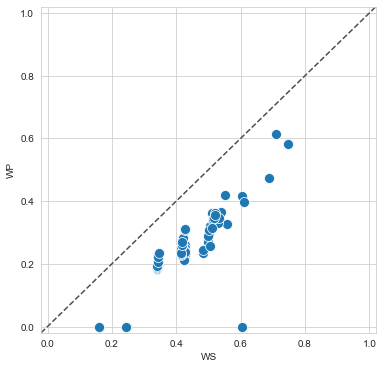

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sns.scatterplot(x = 'WS',
                y = 'WP',
                s = 100,
                data = clean_data)

ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)

diag_line, = ax.plot(ax.get_xlim(), 
                     ax.get_ylim(), 
                     ls="--", 
                     c=".3")

plt.show()

<a id="TOPSIS_Method"> </a>
# Technique 3: TOPSIS

We will now consider the TOPSIS technique. TOPSIS stands for <b>T</b>echnique for <b>O</b>rder of <b>P</b>reference by <b>S</b>imilarity to <b>I</b>deal <b>S</b>olution. From https://en.wikipedia.org/wiki/TOPSIS (accessed on 2/8/18):

> TOPSIS is a multi-criteria decision analysis method, which was originally developed by Hwang and Yoon in 1981 with further developments by Yoon in 1987, and Hwang, Lai and Liu in 1993. TOPSIS is based on the concept that the chosen alternative should have the shortest geometric distance from the positive ideal solution (PIS) and the longest geometric distance from the negative ideal solution (NIS). It is a method of compensatory aggregation that compares a set of alternatives by identifying weights for each criterion, normalising scores for each criterion and calculating the geometric distance between each alternative and the ideal alternative, which is the best score in each criterion. An assumption of TOPSIS is that the criteria are monotonically increasing or decreasing. Normalisation is usually required as the parameters or criteria are often of incongruous dimensions in multi-criteria problems. Compensatory methods such as TOPSIS allow trade-offs between criteria, where a poor result in one criterion can be negated by a good result in another criterion.

The following code cell generates an interactive plot that illustrates the location of the *positive ideal solution* (PIS) and *negative ideal solution* (NIS) for a dataset with two criterion. Note that this representation assumes that higher values of each criteria are better.

[Back to Table of Contents](#Table_of_Contents)<br>

In [27]:
np.random.seed(0)
x = np.random.rand(20)*9+1
y = np.random.rand(20)*9+1

min_x = min(x)
max_x = max(x)
min_y = min(y)
max_y = max(y)

show_IS_list = [False, True]

from ipywidgets import interact

@interact(show_IS = show_IS_list)

def interactive_plot(show_IS = show_IS_list[0]):
    
    fig, ax = plt.subplots(figsize = (6, 6))

    ax.scatter(x, y, s = 100)
    ax.set_xlim(0,11)
    ax.set_ylim(0,11)
    ax.set_xlabel('Criterion x', fontsize = 16)
    ax.set_ylabel('Criterion y', fontsize = 16)
    if show_IS:
        ax.axvline(max_x, linestyle = '--', color = 'k')
        ax.axhline(min_y, linestyle = '--', color = 'k')
        ax.axhline(max_y, linestyle = '--', color = 'k')
        ax.axvline(min_x, linestyle = '--', color = 'k')
        ax.axvline(max_x, linestyle = '--', color = 'k')
        ax.scatter(min_x, min_y, color = 'k', s = 200)
        ax.scatter(max_x, max_y, color = 'k', s = 200)
        ax.annotate('NIS', xy = (min_x + 1, min_y +1), fontsize = 16)
        ax.annotate('PIS', xy = (max_x + 0.5, max_y - 1.4), fontsize = 16)
        ax.arrow(min_x + 1, min_y +1, -0.6, -0.6, head_width=0.3, head_length=0.3, fc='k', ec='k')
        ax.arrow(max_x + 0.5, max_y - 1, -0.3, 0.5, head_width=0.3, head_length=0.3, fc='k', ec='k')

    plt.show()

interactive(children=(Dropdown(description='show_IS', options=(False, True), value=False), Output()), _dom_cla…

The TOPSIS process is carried out as follows (from https://en.wikipedia.org/wiki/TOPSIS (accessed on 2/8/18)):

> #### Step 1:
>Create an evaluation matrix consisting of m alternatives and n criteria, with the intersection of each alternative and criteria given as $\displaystyle x_{ij}$, we therefore have a matrix $\displaystyle (x_{ij})_{m\times n}$.
> 
> #### Step 2:
> The matrix $\displaystyle (x_{ij})_{m\times n}$ is then normalized to form the matrix $R = \displaystyle (r_{ij})_{m\times n}$, using the normalization method $\displaystyle r_{ij} = \frac{x_{ij}}{\sqrt{\sum_{i=1}^{m}x^{2}_{ij}}}, i = 1,2,\ldots,m,~j = 1,2,\ldots,n$.
>
> #### Step 3:
> Calculate the weighted normalized decision matrix $\displaystyle t_{ij}=r_{ij}\cdot w_{j},~i=1,2,...,m,~j=1,2,...,n$, where $\displaystyle w_{j}=W_{j}/\sum _{j=1}^{n}W_{j},~j=1,2,...,n$ so that $\displaystyle \sum _{j=1}^{n}w_{j}=1$, and $W_{j}$ is the original weight given to indicator $\displaystyle v_{j},~j=i,2,\ldots,n$.
>
> #### Step 4: 
> Determine the worst alternative $\displaystyle (A_{w})$ and the best alternative $\displaystyle (A_{b})$:
>
> $$A_{w}=\{\langle max(t_{{ij}}|i=1,2,...,m)|j\in J_{-}\rangle ,\langle min(t_{{ij}}|i=1,2,...,m)|j\in J_{+}\rangle \rbrace \equiv \{t_{{wj}}|j=1,2,...,n\rbrace,$$
>
> $$\displaystyle A_{b}=\{\langle min(t_{ij}|i=1,2,...,m)|j\in J_{-}\rangle ,\langle max(t_{ij}|i=1,2,...,m)|j\in J_{+}\rangle \rbrace \equiv \{t_{bj}|j=1,2,...,n\},$$
>
> where,
$\displaystyle J_{+}=\{j=1,2,...,n|j\}$ associated with the criteria having a positive impact, and
$\displaystyle J_{-}=\{j=1,2,...,n|j\}$ associated with the criteria having a negative impact.
>
> #### Step 5:
> Calculate the L2-distance between the target alternative $\displaystyle i$ and the worst condition $\displaystyle A_{w}$,
>
> $$\displaystyle d_{iw}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{wj})^{2}}},i=1,2,...,m,$$
>
> and the distance between the alternative $\displaystyle i$ and the best condition $\displaystyle A_{b}$,
>
> $$\displaystyle d_{ib}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{bj})^{2}}},i=1,2,...,m,$$
>
> where $\displaystyle d_{iw}$ and $\displaystyle d_{ib}$ are L2-norm distances from the target alternative $\displaystyle i$ to the worst and best conditions, respectively.
>
> #### Step 6
> Calculate the similarity to the worst condition:
>
> $$\displaystyle s_{iw}=d_{iw}/(d_{iw}+d_{ib}),0\leq s_{iw}\leq 1,i=1,2,...,m.$$
>
> $\displaystyle s_{iw}=1$ if and only if the alternative solution has the best condition; and
>
> $\displaystyle s_{iw}=0$ if and only if the alternative solution has the worst condition.
>
> #### Step 7
> Rank the alternatives according to $\displaystyle s_{iw}(i=1,2,...,m)$.

The following code block performs these steps on our data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [28]:
#Step 0 - create copy of data and get evaluation columns
temp_df = clean_data.copy()
criteria_columns = list(weights.keys())
criteria_columns = [col for col in criteria_columns if col in temp_df.columns]

#Step 1
evaluation_matrix = temp_df[criteria_columns].values

#Step 2
squared_evaluation_matrix = evaluation_matrix**2
normalized_evaluation_matrix = evaluation_matrix/np.sqrt(np.sum(squared_evaluation_matrix, axis=0))

#Step 3
weight_values = list(weights.values())
weight_values = np.array(weight_values)
weight_values = weight_values/weight_values.sum()
weighted_matrix = normalized_evaluation_matrix * weight_values

#Step 4
PIS = np.max(weighted_matrix, axis=0)
NIS = np.min(weighted_matrix, axis=0)

#Step 5
intermediate = (weighted_matrix - PIS)**2
Dev_Best = np.sqrt(intermediate.sum(axis = 1))

intermediate = (weighted_matrix - NIS)**2
Dev_Worst = np.sqrt(intermediate.sum(axis = 1))

#Step 6
Closeness = Dev_Worst/(Dev_Best+Dev_Worst)

temp_df['TOPSIS Score'] = Closeness.tolist()

temp_df.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual,WS,WP,TOPSIS Score
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015,0.426,0.236,0.162
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000,0.746,0.582,0.701
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036,0.502,0.307,0.213
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007,0.245,0.000,0.064
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002,0.244,0.000,0.063


The following code block specifies a function for computing the TOPSIS score.

[Back to Table of Contents](#Table_of_Contents)<br>

In [29]:
def compute_TOPSIS(data, weights_dict):
    """
    Computes TOPSIS score for specified columns

    Arguments
    ----------
    data : a pandas DataFrame object that contains the columns to be weighted and the
    normalized scores for each alternative
    
    weights_dict: a dictionary containing the columns to be included in the weighted product as keys,
    and the associated values as values
    
    Returns
    ------
    A list specifying the TOPSIS calculations
           
    """   
    
    #Step 0 
    temp_df = data.copy()
    criteria_columns = list(weights_dict.keys())
    criteria_columns = [col for col in criteria_columns if col in temp_df.columns]

    #Step 1
    evaluation_matrix = temp_df[criteria_columns].values

    #Step 2
    squared_evaluation_matrix = evaluation_matrix**2
    normalized_evaluation_matrix = evaluation_matrix/np.sqrt(np.sum(squared_evaluation_matrix, axis=0))

    #Step 3
    weight_values = list(weights_dict.values())
    weight_values = np.array(weight_values)
    weight_values = weight_values/weight_values.sum()
    weighted_matrix = normalized_evaluation_matrix * weight_values

    #Step 4
    PIS = np.max(weighted_matrix, axis=0)
    NIS = np.min(weighted_matrix, axis=0)

    #Step 5
    intermediate = (weighted_matrix - PIS)**2
    Dev_Best = np.sqrt(intermediate.sum(axis = 1))

    intermediate = (weighted_matrix - NIS)**2
    Dev_Worst = np.sqrt(intermediate.sum(axis = 1))

    #Step 6
    Closeness = Dev_Worst/(Dev_Best+Dev_Worst)

    #Step 7
    return Closeness.tolist()

The folowing code block applies our TOPSIS function to the `clean_data` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [30]:
clean_data['TOPSIS'] = compute_TOPSIS(clean_data, weights)

clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual,WS,WP,TOPSIS
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015,0.426,0.236,0.162
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000,0.746,0.582,0.701
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036,0.502,0.307,0.213
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007,0.245,0.000,0.064
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002,0.244,0.000,0.063


The following code block generates a plot comparing the three ranking methods.

[Back to Table of Contents](#Table_of_Contents)<br>

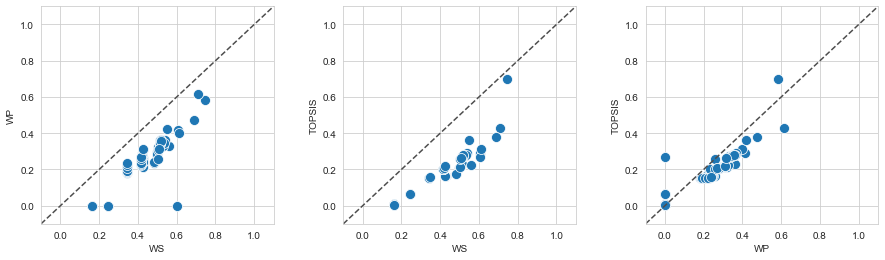

In [31]:
import itertools

model_list = ['WS', 'WP', 'TOPSIS']
model_combinations = list(itertools.combinations(model_list, r = 2))

fig, ax = plt.subplots(1, len(model_combinations), figsize = (15, 4))

for ((model1, model2), current_ax) in zip(model_combinations, ax):
    
    sns.scatterplot(x = model1,
                    y = model2,
                    s = 100,
                    ax = current_ax,
                    data = clean_data)

    current_ax.set_xlim(-0.1, 1.1)
    current_ax.set_ylim(-0.1, 1.1)

    diag_line, = current_ax.plot(current_ax.get_xlim(), 
                                 current_ax.get_ylim(), 
                                 ls="--", 
                                 c=".3")

plt.subplots_adjust(wspace = 0.3)
plt.show()

<a id="mcdm_functions"> </a>
# The mcdm_functions module

Up to this point, we have built functions in the current notebook to apply our ranking methods. In practice, we probably would like to define the functions in a separate file that we can import like `pandas` or `numpy`. The following code block imports such a `module`, which should be saved in the current working directory (the directory where this notebook resides).

[Back to Table of Contents](#Table_of_Contents)<br>

In [32]:
import mcdm_functions as mcdm

We will demonstrate the functionality available in the module using a fresh copy of the data we previously cleaned.

[Back to Table of Contents](#Table_of_Contents)<br>

In [33]:
columns_to_keep = ['Company Name', 
                   'City', 
                   'State', 
                   'ZIP Code',
                   'Open Saturday',
                   'Open Sunday', 
                   'Credit Score Num', 
                   'Zip Code Score', 
                   'Location Sales Volume Actual']

clean_data = tr_data[columns_to_keep].copy()
clean_data = clean_data.reset_index(drop = True)
clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,1158000
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,76161000
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,2774000
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,555000
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,179000


For now, we will use the same weights. The dictionary of weights is recreated below.

[Back to Table of Contents](#Table_of_Contents)<br>

In [34]:
weights = {'Open Saturday': 3,
           'Open Sunday': 2, 
           'Credit Score Num': 9, 
           'Zip Code Score': 7,
           'Location Sales Volume Actual': 4}

In the imported module, which we gave the alias `mcdm`, there is a function named `normalize_weights_dictionary`. This function accepts a dictionary of weights as an input, and returns a copy of the dictionary with the weight values normalized.

[Back to Table of Contents](#Table_of_Contents)<br>

In [35]:
weights = mcdm.normalize_weights_dictionary(weights)
weights

{'Open Saturday': 0.12,
 'Open Sunday': 0.08,
 'Credit Score Num': 0.36,
 'Zip Code Score': 0.28,
 'Location Sales Volume Actual': 0.16}

Note that in our *refreshed* version of the data, the `Location Sales Volume Actual` column is not normalized. The `mcdm` module contains a function named `normalize_array` that will uses the `MinMaxScaler` from scikit-learn to normalize a single array of numbers proved as a list, a pandas Series, or a numpy array.  

[Back to Table of Contents](#Table_of_Contents)<br>

In [36]:
clean_data['Location Sales Volume Actual'] = mcdm.normalize_array(clean_data['Location Sales Volume Actual'])
clean_data

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002
...,...,...,...,...,...,...,...,...,...
144,"Watson, Tony",Franklin,TN,37064,0.100,0.100,0.500,0.500,0.014
145,West Tn Transportation Inc,Germantown,TN,38138,0.100,0.100,0.500,0.500,0.024
146,Worldwide Freight Corp,Chattanooga,TN,37421,0.100,0.100,0.500,0.500,0.034
147,Xcricket Sales,Murfreesboro,TN,37129,0.100,0.100,0.000,0.500,0.003


The `mcdm` module three functions that allow us to compute the weighted sum (`compute_weighted_sum`), the weighted product (`compute_weighted_product`), and the TOPSIS (`compute_TOPSIS`) scores for a provided DataFrame. The values in the passed DataFrame should be normalized before running any of these functions. The functions also accept a dictionary of weights, where the `keys` match columns in the DataFrame. The weight `values` in the dictionary should be normalized.

[Back to Table of Contents](#Table_of_Contents)<br>

In [37]:
clean_data['WS'] = mcdm.compute_weighted_sum(clean_data, weights)
clean_data['WP'] = mcdm.compute_weighted_product(clean_data, weights)
clean_data['TOPSIS'] = mcdm.compute_TOPSIS(clean_data, weights)

The first five rows of the data, after applying our functions, are shown below.

[Back to Table of Contents](#Table_of_Contents)<br>

In [38]:
clean_data.head()

,Company Name,City,State,ZIP Code,Open Saturday,Open Sunday,Credit Score Num,Zip Code Score,Location Sales Volume Actual,WS,WP,TOPSIS
0,AAT Carriers,Jasper,AL,35501,0.100,0.100,0.500,0.800,0.015,0.426,0.236,0.162
1,Alabama Motor Express,Ashford,AL,36312,0.100,0.100,0.950,0.800,1.000,0.746,0.582,0.701
2,All Pro Inc,Northport,AL,35476,0.100,0.100,0.700,0.800,0.036,0.502,0.307,0.213
3,American Way LLC,Cottondale,AL,35453,0.100,0.100,0.000,0.800,0.007,0.245,0.000,0.064
4,Baggetts Trucking,Piedmont,AL,36272,0.100,0.100,0.000,0.800,0.002,0.244,0.000,0.063


<a id="AHP"> </a>
# Weight Determination via Analytic Hierarchy Process (AHP)

We will now turn our attention to setting weights for a supplier ranking task. This can be a particularly challenging process because the fact that we are including an attribute means it is important to some degree. In this section, we will investigate a technique known as Analytics Heirarchy Process for setting weights. From https://en.wikipedia.org/wiki/Analytic_hierarchy_process (accessed 2/4/2019):

> The analytic hierarchy process (AHP) is a structured technique for organizing and analyzing complex decisions, based on mathematics and psychology. It was developed by Thomas L. Saaty in the 1970s and has been extensively studied and refined since then.
>
> Rather than prescribing a "correct" decision, the AHP helps decision makers find one that best suits their goal and their understanding of the problem. It provides a comprehensive and rational framework for structuring a decision problem, for representing and quantifying its elements, for relating those elements to overall goals, and for evaluating alternative solutions.
>
> Decision makers systematically evaluate its various [attributes] by comparing them to each other two at a time, with respect to their impact on [a predetermined objective]. In making the comparisons, the decision makers can use concrete data about the elements, but they typically use their judgments about the elements' relative meaning and importance. It is the essence of the AHP that human judgments, and not just the underlying information, can be used in performing the evaluations.
>
> The AHP converts these evaluations to numerical values that can be processed and compared over the entire range of the problem. A numerical weight or priority is derived for each [attribute], allowing diverse and often incommensurable elements to be compared to one another in a rational and consistent way. This capability distinguishes the AHP from other decision making techniques.
>
> In the final step of the process, numerical priorities are calculated for each of the decision alternatives. These numbers represent the alternatives' relative ability to achieve the decision goal, so they allow a straightforward consideration of the various courses of action.

The pairwise evaluations performed in an AHP analysis follow the rubric provided in the table that follows.

<table border="1" class="colwidths-given docutils">
<colgroup>
<col width="20%" />
<col width="20%" />
<col width="60%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd" style="text-align:center"><th class="head">Intensity of Importance</th>
<th class="head" style="text-align:left">Definition</th>
<th class="head" style="text-align:left">Explanation</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even">
    <td style="text-align:center">$\frac{1}{9} \approx 0.111$</td>
    <td style="text-align:left">Extreme Unimportance</td>
    <td style="text-align:left">Criterion A is extremely less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">$\frac{1}{7}\approx 0.143$</td>
    <td style="text-align:left">Very Strong Unimportance</td>
    <td style="text-align:left">Criterion A is very strongly less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">$\frac{1}{5} = 0.2$</td>
    <td style="text-align:left">Strong Unimportance</td>
    <td style="text-align:left">Criterion A is strongly less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">$\frac{1}{3}\approx 0.333$</td>
    <td style="text-align:left">Moderate Unimportance</td>
    <td style="text-align:left">Criterion A is moderately less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">1</td>
    <td style="text-align:left">Equal Importance</td>
    <td style="text-align:left">Criterion A is equally important as criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">3</td>
    <td style="text-align:left">Moderate Importance</td>
    <td style="text-align:left">Criterion A is moderately preferable to criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">5</td>
    <td style="text-align:left">Strong Importance</td>
    <td style="text-align:left">Criterion A is strongly preferable to criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">7</td>
    <td style="text-align:left">Very Strong Importance</td>
    <td style="text-align:left">Criterion A is very strongly preferable to criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">9</td>
    <td style="text-align:left">Extreme Importance</td>
    <td style="text-align:left">Criterion A is extremely preferable to criterion B with respect to the objective</td>
</tr>
</tbody>
</table>

A challenging aspect of performing an AHP analysis in Python is collecting the evaluation data and ensuring everything is in the correct format. Thus, we will utilize an automated approach that will be demonstrated shortly. First, let's use a small dataset on cereal preferences to demonstrate how AHP works.

[Back to Table of Contents](#Table_of_Contents)<br>

In [39]:
comparison_data = [
    [1, 5, 9],
    [0.2, 1, 4],
    [0.111, 0.25, 1]
]

index_vals = ['Lucky Charms', 'Trix', 'Frosted Flakes']

cereal_data = pd.DataFrame(comparison_data, index = index_vals, columns = index_vals)
cereal_data

,Lucky Charms,Trix,Frosted Flakes
Lucky Charms,1.000,5.000,9
Trix,0.200,1.000,4
Frosted Flakes,0.111,0.250,1


We can use the `values` attribute of a pandas DataFrame to get the values as a numpy array.

[Back to Table of Contents](#Table_of_Contents)<br>

In [40]:
cereal_scores = cereal_data.values
cereal_scores

array([[1.   , 5.   , 9.   ],
       [0.2  , 1.   , 4.   ],
       [0.111, 0.25 , 1.   ]])

### Step 1

Calculate column sums for the evaluation matrix.

[Back to Table of Contents](#Table_of_Contents)<br>

In [41]:
column_sums = np.sum(cereal_scores,axis=0)
column_sums

array([ 1.311,  6.25 , 14.   ])

### Step 2

Divide all scores in the evaluation matrix by the column sums.

[Back to Table of Contents](#Table_of_Contents)<br>

In [42]:
scores_divided_by_sums = cereal_scores/column_sums
scores_divided_by_sums

array([[0.76277651, 0.8       , 0.64285714],
       [0.1525553 , 0.16      , 0.28571429],
       [0.08466819, 0.04      , 0.07142857]])

### Step 3

Create a prority vector by determining the average score in each row of the updated evaluation matrix.

[Back to Table of Contents](#Table_of_Contents)<br>

In [43]:
priority_vector = np.average(scores_divided_by_sums, axis=1)
priority_vector   

array([0.73521122, 0.1994232 , 0.06536559])

### Step 4

Approximate the maximum eigenvalue of the evaluation matrix by computing the inner product of the priority vector and the column sums.

[Back to Table of Contents](#Table_of_Contents)<br>

In [44]:
max_eigenvalue = np.inner(priority_vector, column_sums)
max_eigenvalue

3.1253751080600054

### Step 5

Compute the consistency index (CI) for the evaluation matrix using the formula:

$$ CI = (\lambda - n)/(n-1),$$

where $\lambda$ represents the maximum eigenvalue and $n$ represents the number of attributes.

[Back to Table of Contents](#Table_of_Contents)<br>

In [45]:
criteria_CI = (max_eigenvalue - len(priority_vector))/(len(priority_vector)-1)
criteria_CI

0.0626875540300027

### Step 6

Compute the consistency ratio (CR) using the formula:

$$ CI/RI_{n},$$

where $RI_{n}$ is given in the following table.

<table border="1" class="colwidths-given docutils">
<colgroup>
<col width="50%" />
<col width="50%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd" style="text-align:center"><th class="head">$n$</th>
<th class="head" style="text-align:center">$RI_{n}$</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even">
    <td style="text-align:center">0</td>
    <td style="text-align:center">0</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">1</td>
    <td style="text-align:center">0</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">2</td>
    <td style="text-align:center">0</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">3</td>
    <td style="text-align:center">0.58</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">4</td>
    <td style="text-align:center">0.9</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">5</td>
    <td style="text-align:center">1.12</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">6</td>
    <td style="text-align:center">1.24</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">7</td>
    <td style="text-align:center">1.32</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">8</td>
    <td style="text-align:center">1.41</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">9</td>
    <td style="text-align:center">1.45</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">10</td>
    <td style="text-align:center">1.49</td>
</tr>


</tbody>
</table>

If $CR < 0.10$, the evaluations are considered to be consistent.

[Back to Table of Contents](#Table_of_Contents)<br>

In [46]:
RI = [0, 0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49] 
criteria_CR = np.round(criteria_CI/RI[len(priority_vector)], 5)
criteria_CR

0.10808

The following code block reruns the example with a set of data that includes inconsistent preferences.

[Back to Table of Contents](#Table_of_Contents)<br>

In [47]:
comparison_data = [
    [1, 5, 9],
    [0.2, 1, 0.25],
    [0.111, 4, 1]
]

index_vals = ['Lucky Charms', 'Trix', 'Frosted Flakes']

cereal_data = pd.DataFrame(comparison_data, index = index_vals, columns = index_vals)

cereal_scores = cereal_data.values

column_sums = np.sum(cereal_scores, axis=0)

scores_divided_by_sums = cereal_scores/column_sums

priority_vector = np.average(scores_divided_by_sums, axis=1)

max_eigenvalue = np.inner(priority_vector, column_sums)

criteria_CI = (max_eigenvalue - len(priority_vector))/(len(priority_vector)-1)

criteria_CR = np.round(criteria_CI/RI[len(priority_vector)], 5)

print(f'The consistency ratio is {criteria_CR}')

cereal_data

The consistency ratio is 0.73101


,Lucky Charms,Trix,Frosted Flakes
Lucky Charms,1.000,5,9.000
Trix,0.200,1,0.250
Frosted Flakes,0.111,4,1.000


The mcdm module includes a function named `create_ahp_rank_matrix_from_gui` that we will use to automate the application of AHP. The function expects a `list` of criteria that should be compared. Suppose that the following list provides our order of relative importance for the selected criteria.

1. `Credit Score Num`
2. `Location Sales Volume Actual`
3. `Zip Code Score`
4. `Open Saturday`
5. `Open Sunday`

Moreover, assume that we have the following preferences using the language of AHP.

- `Credit Score Num` is **moderately more preferable** than `Location Sales Volume Actual`
- `Credit Score Num` is **strongly more preferable** than `Zip Code Score`
- `Credit Score Num` is **very strongly more preferable** than `Open Saturday`
- `Credit Score Num` is **extremely more preferable** than `Open Sunday`
- `Location Sales Volume Actual` is **moderately more preferable** than `Zip Code Score`
- `Location Sales Volume Actual` is **strongly more preferable** than `Open Saturday`
- `Location Sales Volume Actual` is **very strongly more preferable** than `Open Sunday`
- `Zip Code Score` is **moderately more preferable** than `Open Saturday`
- `Zip Code Score` is **strongly more preferable** than `Open Sunday`
- `Open Saturday` is **moderately more preferable** than `Open Sunday`

You may correctly suspect that we can just past the `keys` of our `weights` dictionary as a `list` to the `create_ahp_rank_matrix_from_gui` function. The following code block shows how to generate such a list.

[Back to Table of Contents](#Table_of_Contents)<br>

In [48]:
list(weights.keys())

['Open Saturday',
 'Open Sunday',
 'Credit Score Num',
 'Zip Code Score',
 'Location Sales Volume Actual']

Although passing such a list is perfectly fine, it is best to provide the criteria in the order of decreasing expected importance. Such a representation for our criteria follows.

[Back to Table of Contents](#Table_of_Contents)<br>

In [49]:
criteria_list = ['Credit Score Num',
 'Location Sales Volume Actual',
 'Zip Code Score',
 'Open Saturday',
 'Open Sunday']

The following code block applies the function.

[Back to Table of Contents](#Table_of_Contents)<br>

In [50]:
# weights = mcdm.create_ahp_rank_matrix_from_gui(criteria_list)

weights = {'Credit Score Num': 0.5028194957704966,
           'Location Sales Volume Actual': 0.2602315877866833,
           'Zip Code Score': 0.1343504405731109,
           'Open Saturday': 0.06777766684747813,
           'Open Sunday': 0.03482080902223112}

We can now apply our weights to our data, overwriting the previous scores.

[Back to Table of Contents](#Table_of_Contents)<br>

In [51]:
clean_data['WS'] = mcdm.compute_weighted_sum(clean_data, weights)
clean_data['WP'] = mcdm.compute_weighted_product(clean_data, weights)
clean_data['TOPSIS'] = mcdm.compute_TOPSIS(clean_data, weights)

The following code block generates scatterplots for the scores found by the three methods.

[Back to Table of Contents](#Table_of_Contents)<br>

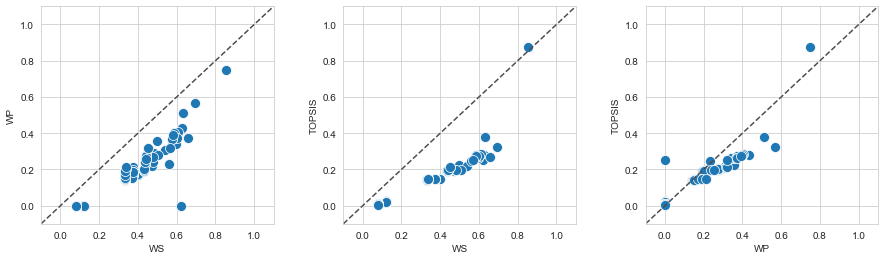

In [52]:
import itertools

model_list = ['WS', 'WP', 'TOPSIS']
model_combinations = list(itertools.combinations(model_list, r = 2))

fig, ax = plt.subplots(1, len(model_combinations), figsize = (15, 4))

for ((model1, model2), current_ax) in zip(model_combinations, ax):
    
    sns.scatterplot(x = model1,
                    y = model2,
                    s = 100,
                    ax = current_ax,
                    data = clean_data)

    current_ax.set_xlim(-0.1, 1.1)
    current_ax.set_ylim(-0.1, 1.1)

    diag_line, = current_ax.plot(current_ax.get_xlim(), 
                                 current_ax.get_ylim(), 
                                 ls="--", 
                                 c=".3")

plt.subplots_adjust(wspace = 0.3)
plt.show()

<a id="Ensemble"> </a>
# Ensemble Approaches

The final topic that we will consider is ensemble methods for supplier selection. The following code block refreshes our data and weights.

[Back to Table of Contents](#Table_of_Contents)<br>

In [53]:
columns_to_keep = ['Company Name', 
                   'City', 
                   'State', 
                   'ZIP Code',
                   'Open Saturday',
                   'Open Sunday', 
                   'Credit Score Num', 
                   'Zip Code Score', 
                   'Location Sales Volume Actual']

clean_data = tr_data[columns_to_keep].copy()
clean_data = clean_data.reset_index(drop = True)
clean_data['Location Sales Volume Actual'] = mcdm.normalize_array(clean_data['Location Sales Volume Actual'])

weights = {'Credit Score Num': 0.5028194957704966,
           'Location Sales Volume Actual': 0.2602315877866833,
           'Zip Code Score': 0.1343504405731109,
           'Open Saturday': 0.06777766684747813,
           'Open Sunday': 0.03482080902223112}

As we saw in our earlier discussion of the weighted sum, weighted product, and TOPSIS ranking methods, there are differences in the rankings produced by each method. Also, whenever we perform a ranking, the weights that we use are based on our preferences at the time that the weights are deterimined. Moreover, if we use a technique such as AHP, the waits my include some inherent bias that is associated with the decision makers involved in deriving the pairiwse attribute comparisons. 

Based on these complications, we will look at the use of ensemble methods to 1) ensure that our supplier rankings are robust to variations in weights and 2) incorporate insights from all three ranking methods.

The following code block defines a function that performs a robust ranking evaluation for a specified scoring method. The function allows a user to define a perturbation range that is used to randomly vary the weights for the various criteria in the range +/- the defined perturbation. This is done for a specified number of times and the number of times that a particular supplier appears as a top supplier is counted and plotted. The function returns a `DataFrame` object with the robust ranking results.

**Additional details on the operation of this function will be provided in class.**

[Back to Table of Contents](#Table_of_Contents)<br>

In [54]:
def robust_ranking(data,
                   weights_dict,
                   index_column,
                   ranking_methods_dict,
                   perturbation_range = 0.1,
                   top_values = 5,
                   perturbations = 100,
                   random_seed = 0):
    
    '''
    Performs a robust ranking procedure that identfies the proportion of times where
    the available alternatives appear as top choice under weight perturbations in the
    range defined by the perturbation_range.

    Parameters
    ----------
    data : a pandas DataFrame object that contains the specified columns
        
    weights_dict: a dictionary containing the columns to be included in the weighted product as keys,
    and the associated values as values
    
    index_column: a string specifying the column of alternatives
    
    ranking_methods_dict: a dictionary with each key specifying a name for each ranking method
    to be used and the corresponding values specifying the function. Each dunction should take
    the data object and the weights_dict object as arguments and return a list with the
    scores for each alternative.
           
    perturbations: an integer specifying the number of times to perturb the weights
    
    top_values: specifies the number of alternatives to keep from each ranking (highest ranked scores kept)
    
    perturbation_range: The perturbation range to consider (expressed as a proportion)    \
    
    random_seed: float specifying seed for random number generator
    

    Yields
    ------
    a DataFrame indicating the proportion of times each alternative appears in top ranking
    '''

    criteria = list(weights_dict.keys())
    
    a = np.zeros(shape = (len(data.index), 
                          len(ranking_methods_dict.keys())+1)
                )

    counts_df = pd.DataFrame(a, columns=[index_column] + list(ranking_methods_dict.keys()))

    counts_df[index_column] = data[index_column]

    starting_weights = np.array(list(weights_dict.values()))

    for perturbation in range(perturbations):
        np.random.seed(perturbation)

        perturbation_vector = 1.0 + np.random.uniform(low = -1.0*perturbation_range,
                                                      high = perturbation_range,
                                                      size= len(starting_weights))

        perturbed_weights = perturbation_vector * starting_weights
        perturbed_weights = list(perturbed_weights/perturbed_weights.sum())
        perturbed_weights_dict = dict(zip(criteria, perturbed_weights))

        for current_ranking_method in ranking_methods_dict.keys():

            temp = pd.DataFrame(ranking_methods_dict[current_ranking_method](data, perturbed_weights_dict),
                                index = data[index_column],
                                columns = [current_ranking_method])

            top_index_vals = temp.nlargest(top_values, 
                                           current_ranking_method).index.tolist()

            counts_df.loc[counts_df[index_column].isin(top_index_vals), current_ranking_method] += 1

    counts_df[list(ranking_methods_dict.keys())] = counts_df[list(ranking_methods_dict.keys())]/perturbations
    counts_df = counts_df.sort_values(list(ranking_methods_dict.keys()), ascending = False)
    mask = counts_df[list(ranking_methods_dict.keys())].sum(axis = 1) > 0
    counts_df = counts_df[mask]
    
    return counts_df

The following code block shows how we can use the function to identify the top 5 suppliers, by each ranking method, when we allow the attribute weights to vary within 20% of the mean weight value.

[Back to Table of Contents](#Table_of_Contents)<br>

In [55]:
ranking_methods = {'WS': mcdm.compute_weighted_sum,
                   'WP': mcdm.compute_weighted_product,
                   'TOPSIS': mcdm.compute_TOPSIS}

robust_rankings = robust_ranking(clean_data,
                                 weights,
                                 'Company Name',
                                 ranking_methods,
                                 perturbation_range = 0.20,
                                 top_values = 5,
                                 perturbations = 100,
                                 random_seed = 0)

robust_rankings

,Company Name,WS,WP,TOPSIS
1,Alabama Motor Express,1.000,1.000,1.000
74,First Fleet Inc,1.000,1.000,1.000
92,JB Hunt Transport Svc Inc,1.000,0.000,0.020
15,Century Carriers,0.960,1.000,0.980
143,W E Graham Inc,0.860,1.000,1.000
24,Gulf South Transportation Inc,0.180,0.000,0.000
85,Heartland Express Inc,0.000,1.000,1.000


A plot of the results follows.

[Back to Table of Contents](#Table_of_Contents)<br>

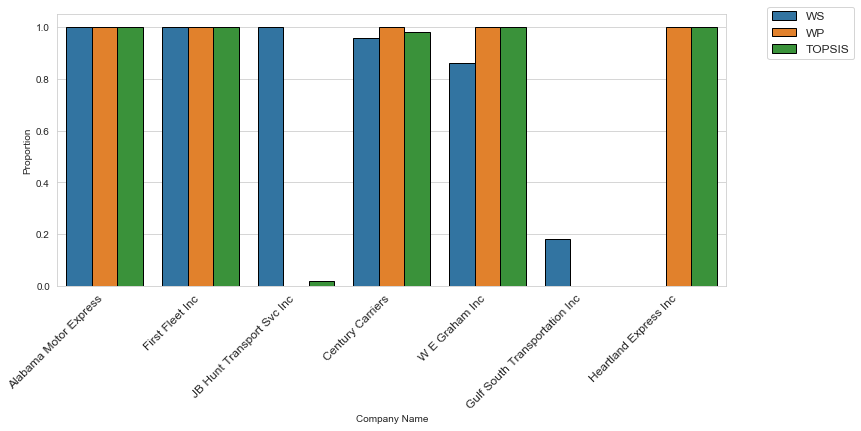

In [56]:
fig, ax = plt.subplots(figsize = (12,5))

melted = robust_rankings.melt(id_vars = ['Company Name'])
melted = melted.rename(columns = {'value':'Proportion',
                                  'variable': 'Method'})

sns.barplot(x = 'Company Name',
            y = 'Proportion',
            edgecolor = 'k',
            hue = 'Method',
            data = melted)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", fontsize = 12)
ax.legend(bbox_to_anchor=(1.2, 1.05), fontsize = 12)

plt.show()